## Descripción de las Variables de Entrada.

`CustomerID`: Identificador único para cada cliente.

`Gender`: Género.

`Age`: Edad.

`Annual Income (k$)`: Ingresos anuales.

`Spending Score (1-100)`: Índice de gastos.

## Importación de librerías.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage

Cargamos el CSV

In [2]:
df = pd.read_csv("Mall_Customers.csv")

## EDA o análisis exploratorio de datos.

In [3]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Buscamos valores nulos

<Axes: >

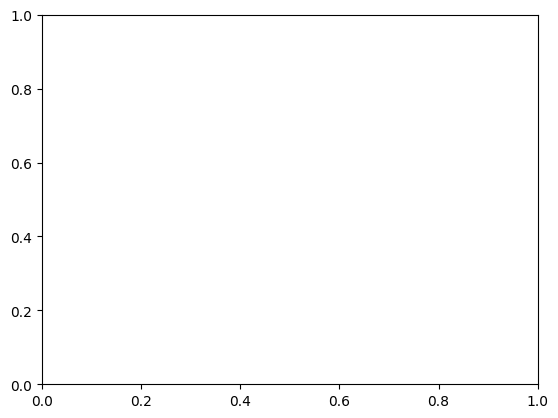

In [5]:
sns.barplot(df.drop(df.dropna(axis=1).columns, axis=1).isna().mean())


"Dividimos" los datos por género

In [6]:
df = pd.get_dummies(df, columns=['Gender'])

In [7]:
df.head(5)

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,1,19,15,39,False,True
1,2,21,15,81,False,True
2,3,20,16,6,True,False
3,4,23,16,77,True,False
4,5,31,17,40,True,False


Empezamos a graficar buscando información valiosa.

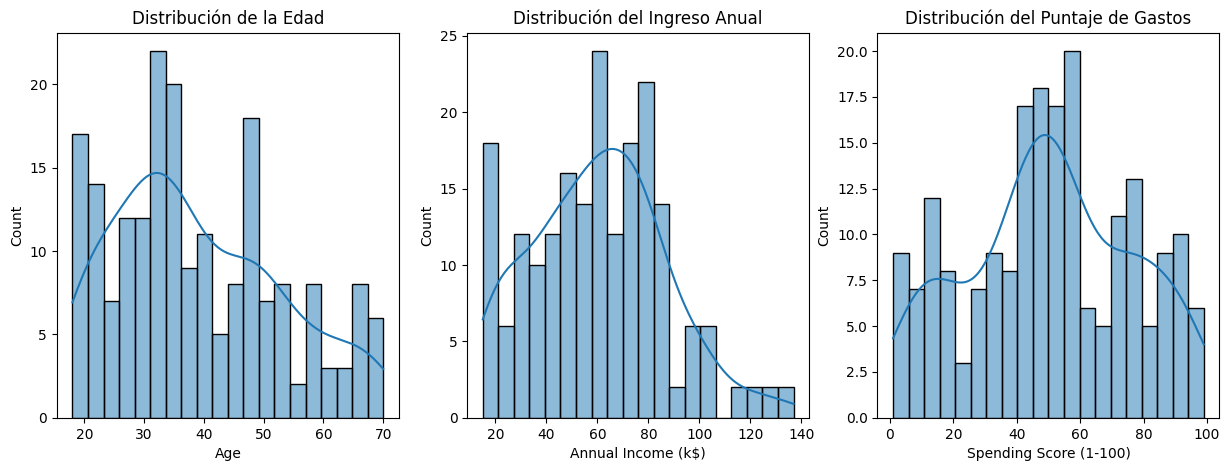

In [8]:
# Histogramas para variables numéricas
plt.figure(figsize=[15,5])
plt.subplot(1, 3, 1)
sns.histplot(df['Age'], kde=True, bins=20)
plt.title('Distribución de la Edad')

plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], kde=True, bins=20)
plt.title('Distribución del Ingreso Anual')

plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], kde=True, bins=20)
plt.title('Distribución del Puntaje de Gastos')
plt.show()


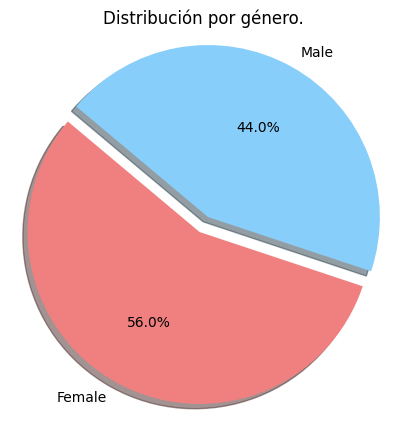

In [9]:
num_female = df['Gender_Female'].sum()  
num_male = df['Gender_Male'].sum()     

labels = 'Female', 'Male'

sizes = [num_female, num_male]

colors = ['lightcoral', 'lightskyblue']

explode = (0.1, 0)  

plt.figure(figsize=[5,5])
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  
plt.title('Distribución por género.')
plt.show()

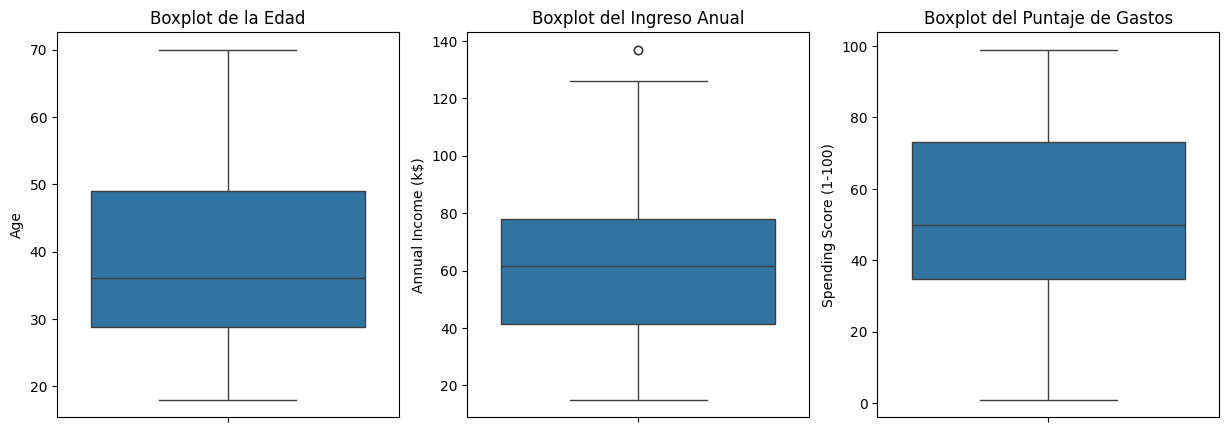

In [10]:
# Boxplots para detectar valores atípicos
plt.figure(figsize=[15,5])
plt.subplot(1, 3, 1)
sns.boxplot(y=df['Age'])
plt.title('Boxplot de la Edad')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['Annual Income (k$)'])
plt.title('Boxplot del Ingreso Anual')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['Spending Score (1-100)'])
plt.title('Boxplot del Puntaje de Gastos')
plt.show()


Hacemos 3 gráficas de distrubución de datos.

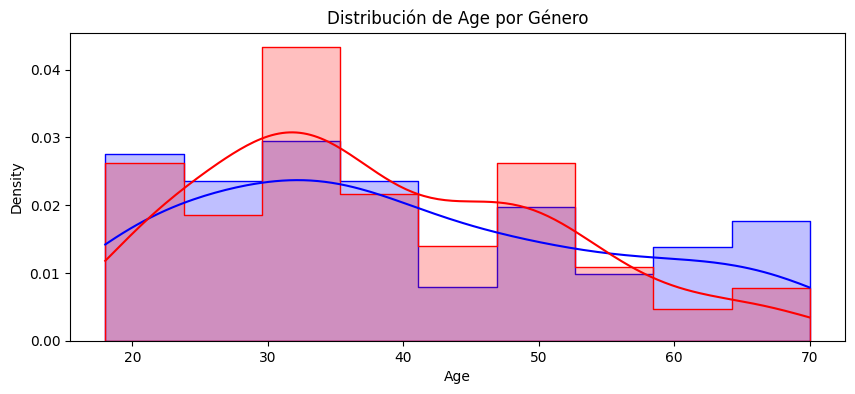

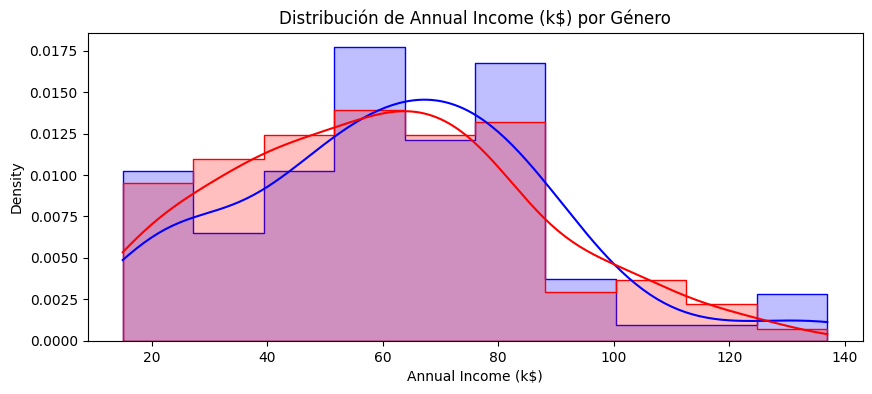

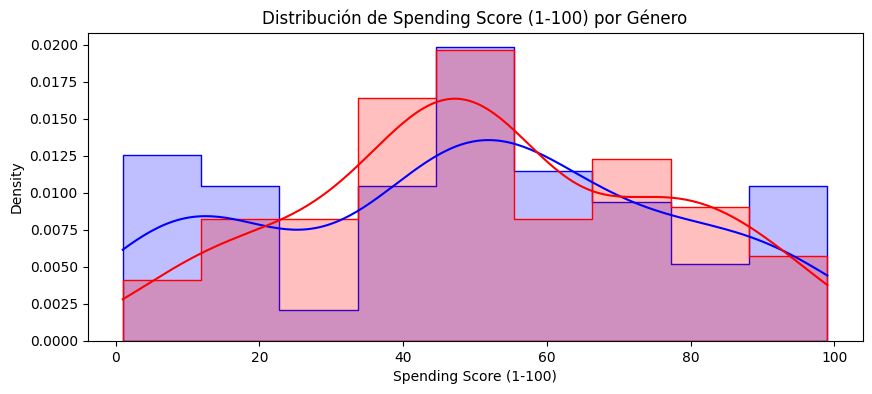

In [11]:
# Definir las características a visualizar.
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Asignar colores manualmente para claridad.
color_map = {0: 'red', 1: 'blue'}  # 0 para mujer y 1 para hombres.

for feature in features:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=feature, hue="Gender_Male", palette=color_map, kde=True, element="step", stat="density", common_norm=False, legend=None)
    plt.title(f'Distribución de {feature} por Género')
    plt.show()


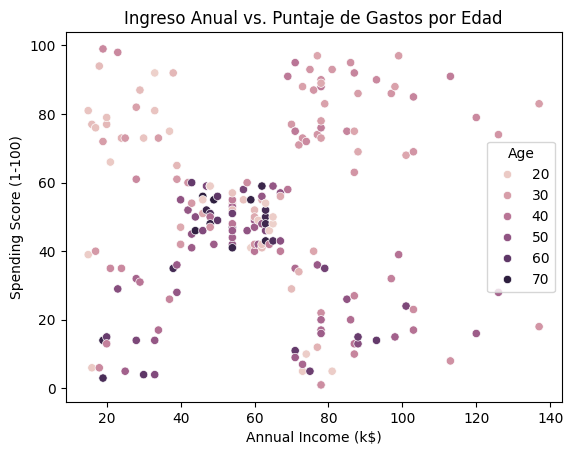

In [12]:
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Age')
plt.title('Ingreso Anual vs. Puntaje de Gastos por Edad')
plt.show()


In [13]:
df.columns

Index(['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Gender_Female', 'Gender_Male'],
      dtype='object')

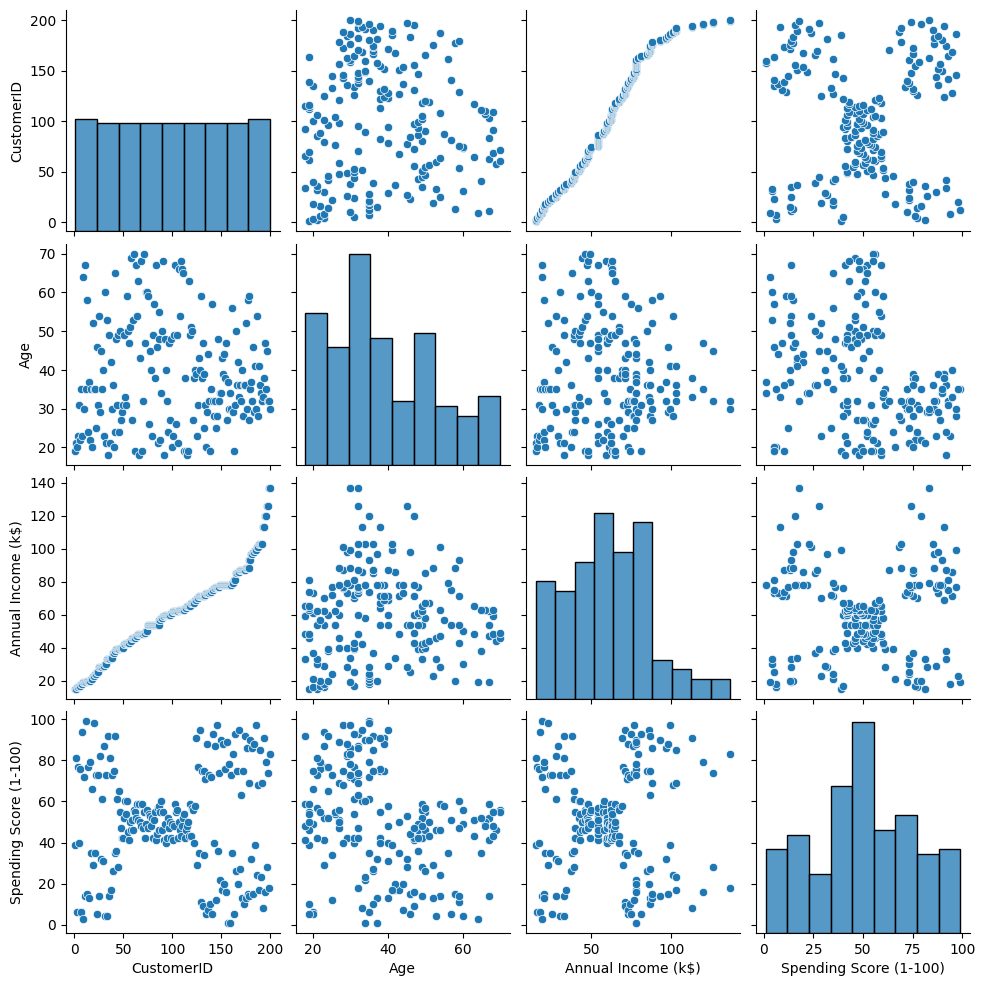

In [14]:
# Gráfico de pares para todas las características
sns.pairplot(df, vars=['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
plt.show()

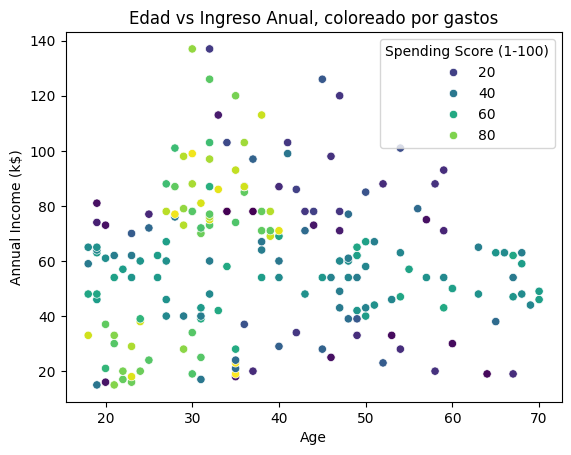

In [15]:
# Usamos un gráfico de dispersión pero esta vez comparando Edad con Ingreso Anual
sns.scatterplot(data=df, x='Age', y='Annual Income (k$)', hue='Spending Score (1-100)', palette='viridis')
plt.title('Edad vs Ingreso Anual, coloreado por gastos')
plt.show()


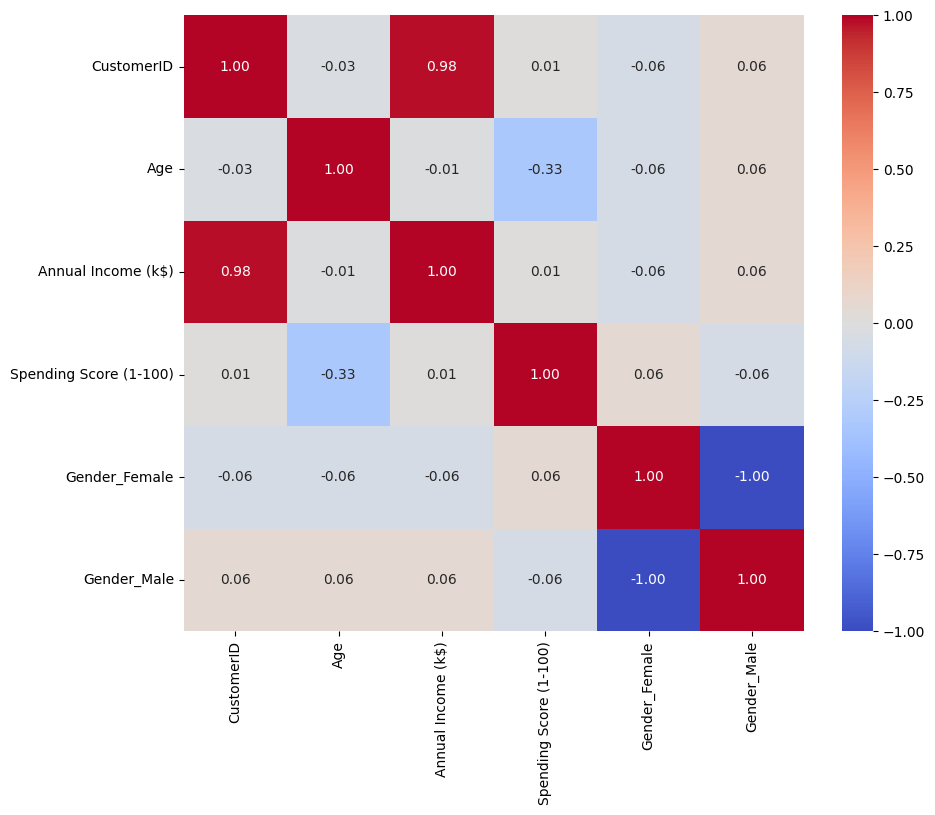

In [16]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


Creación de tres columnas nuevas: Age_Group, Income_Level y Spending_level. 

`Age_Group`: Al igual que la columna Age, es la edad, pero la categorizamos en tres grupo: jóvenes, adultos y mayores.

`Income_Level`: Al igual que la columna Annual_Income, pero también la categorizamos.

`Spending_level`: Y como no podía ser de otra forma, la columna Spending_Level también la hacemos categoría.

In [17]:
# Asegurándonos de que los bins cubran todos los valores posibles
bins_age = [17, 31, 60, df['Age'].max() + 1]  
labels_age = ['Young', 'Adult', 'Elder']
df['Age_Group'] = pd.cut(df['Age'], bins=bins_age, labels=labels_age, right=False)  

# Ajustando bins para 'Annual Income (k$)' para asegurar cobertura completa
bins_income = [-np.inf, np.percentile(df['Annual Income (k$)'], 33), np.percentile(df['Annual Income (k$)'], 66), np.inf]
labels_income = ['Low', 'Medium', 'High']
df['Income_Level'] = pd.cut(df['Annual Income (k$)'], bins=bins_income, labels=labels_income)

# Ajustando bins para 'Spending Score (1-100)' para asegurar cobertura completa
bins_spending = [-np.inf, np.percentile(df['Spending Score (1-100)'], 33), np.percentile(df['Spending Score (1-100)'], 66), np.inf]
labels_spending = ['Low', 'Medium', 'High']
df['Spending_Level'] = pd.cut(df['Spending Score (1-100)'], bins=bins_spending, labels=labels_spending)

# Verificar nuevamente los cambiosDes
df.head()


,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,Age_Group,Income_Level,Spending_Level
0,1,19,15,39,False,True,Young,Low,Low
1,2,21,15,81,False,True,Young,Low,High
2,3,20,16,6,True,False,Young,Low,Low
3,4,23,16,77,True,False,Young,Low,High
4,5,31,17,40,True,False,Adult,Low,Low


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CustomerID              200 non-null    int64   
 1   Age                     200 non-null    int64   
 2   Annual Income (k$)      200 non-null    int64   
 3   Spending Score (1-100)  200 non-null    int64   
 4   Gender_Female           200 non-null    bool    
 5   Gender_Male             200 non-null    bool    
 6   Age_Group               200 non-null    category
 7   Income_Level            200 non-null    category
 8   Spending_Level          200 non-null    category
dtypes: bool(2), category(3), int64(4)
memory usage: 7.7 KB


Aplicamos el metodo `get_dummies` en las nuevas columnas catégoricas y creamos nuevas columnas con valor 0 y 1. 


In [19]:
dummies = pd.get_dummies(df[['Age_Group', 'Income_Level', 'Spending_Level']])
# Unimos las variables dummy con los datos originales
df_model = pd.concat([df, dummies], axis=1)
# Eliminamos las columnas originales categóricas
df_model.drop(['Annual Income (k$)', 'Spending Score (1-100)', 'Age_Group', 'Income_Level', 'Spending_Level'], axis=1, inplace=True)


In [20]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   CustomerID             200 non-null    int64
 1   Age                    200 non-null    int64
 2   Gender_Female          200 non-null    bool 
 3   Gender_Male            200 non-null    bool 
 4   Age_Group_Young        200 non-null    bool 
 5   Age_Group_Adult        200 non-null    bool 
 6   Age_Group_Elder        200 non-null    bool 
 7   Income_Level_Low       200 non-null    bool 
 8   Income_Level_Medium    200 non-null    bool 
 9   Income_Level_High      200 non-null    bool 
 10  Spending_Level_Low     200 non-null    bool 
 11  Spending_Level_Medium  200 non-null    bool 
 12  Spending_Level_High    200 non-null    bool 
dtypes: bool(11), int64(2)
memory usage: 5.4 KB


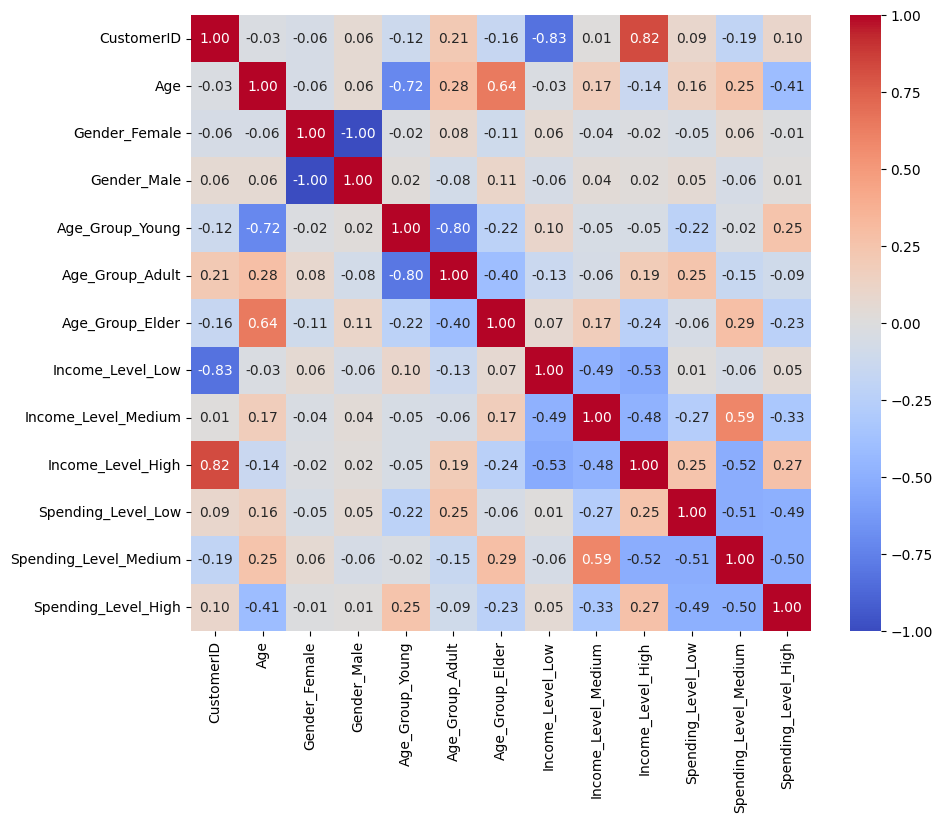

In [21]:
plt.figure(figsize=(10, 8))
corr_matrix = df_model.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


In [22]:
df_model.columns

Index(['CustomerID', 'Age', 'Gender_Female', 'Gender_Male', 'Age_Group_Young',
       'Age_Group_Adult', 'Age_Group_Elder', 'Income_Level_Low',
       'Income_Level_Medium', 'Income_Level_High', 'Spending_Level_Low',
       'Spending_Level_Medium', 'Spending_Level_High'],
      dtype='object')

## Machine learning

Y empieza la magia. 

Vamos a realizar un proyecto de clustering o segmentación sobre la BBDD de los clientes.

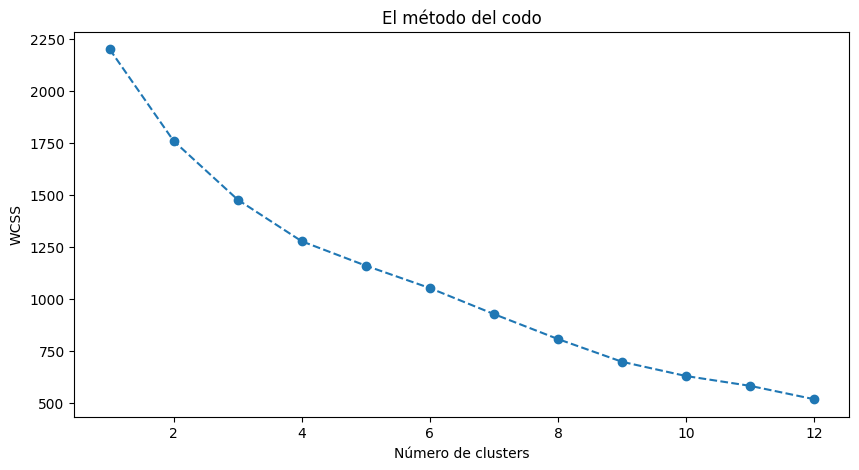

In [23]:
X = df_model[['Gender_Female', 'Gender_Male', 'Age_Group_Young', 'Age_Group_Adult',
            'Age_Group_Elder', 'Income_Level_Low', 'Income_Level_Medium',
            'Income_Level_High', 'Spending_Level_Low', 'Spending_Level_Medium',
            'Spending_Level_High']]

# Normalizamos las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Determinando el número óptimo de clusters
wcss = []
for i in range(1, 13):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init='auto', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1, 13), wcss, marker='o', linestyle='--')
plt.title('El método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()


In [24]:
# Aplicando K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init='auto', random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

df_model['Cluster'] = y_kmeans

print(df_model['Cluster'].value_counts())

for i in range(7):
    print(f"\nCluster {i} characteristics:")
    print(df_model[df_model['Cluster'] == i].select_dtypes(include=[np.number]).mean())


Cluster
2    38
6    33
1    30
0    29
3    25
4    24
5    21
Name: count, dtype: int64

Cluster 0 characteristics:
CustomerID    103.379310
Age            45.137931
Cluster         0.000000
dtype: float64

Cluster 1 characteristics:
CustomerID    167.100000
Age            38.766667
Cluster         1.000000
dtype: float64

Cluster 2 characteristics:
CustomerID    75.263158
Age           27.736842
Cluster        2.000000
dtype: float64

Cluster 3 characteristics:
CustomerID    164.28
Age            36.52
Cluster         3.00
dtype: float64

Cluster 4 characteristics:
CustomerID    24.375000
Age           45.291667
Cluster        4.000000
dtype: float64

Cluster 5 characteristics:
CustomerID    59.142857
Age           43.809524
Cluster        5.000000
dtype: float64

Cluster 6 characteristics:
CustomerID    99.848485
Age           40.121212
Cluster        6.000000
dtype: float64


In [25]:
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

df_model['Cluster'] = y_kmeans

print(df_model['Cluster'].value_counts())

for i in range(5):
    print(f"\nCluster {i} characteristics:")
    print(df_model[df_model['Cluster'] == i].select_dtypes(include=[np.number]).mean())


Cluster
6    31
2    31
1    25
5    23
7    20
4    20
3    20
8    17
0    13
Name: count, dtype: int64

Cluster 0 characteristics:
CustomerID    169.384615
Age            28.846154
Cluster         0.000000
dtype: float64

Cluster 1 characteristics:
CustomerID    96.00
Age           46.68
Cluster        1.00
dtype: float64

Cluster 2 characteristics:
CustomerID    140.741935
Age            35.225806
Cluster         2.000000
dtype: float64

Cluster 3 characteristics:
CustomerID    159.5
Age            39.5
Cluster         3.0
dtype: float64

Cluster 4 characteristics:
CustomerID    96.25
Age           21.60
Cluster        4.00
dtype: float64


### Hierarchical clustering

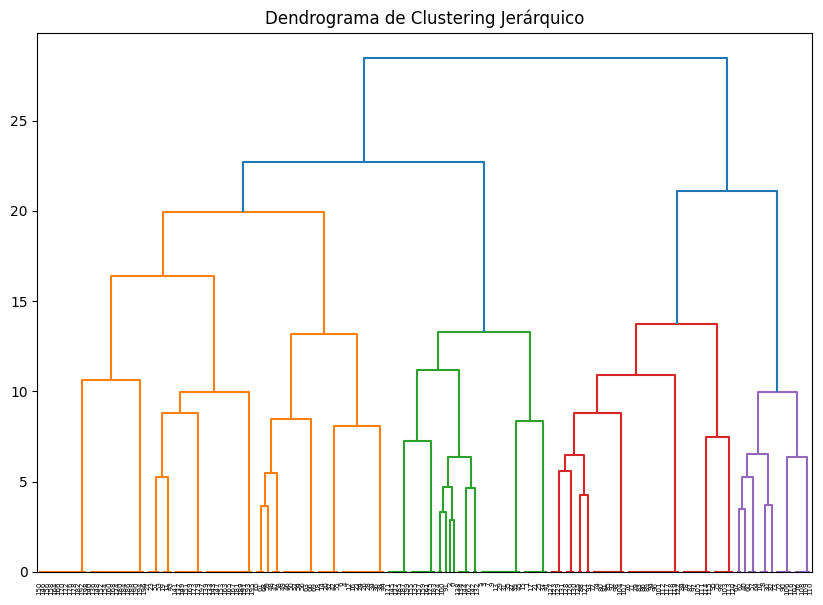

In [26]:
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrograma de Clustering Jerárquico')
plt.show()


In [27]:
n_clusters = 9

# Aplicar clustering jerárquico
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

labels = clustering.fit_predict(X_scaled)

df_model['Cluster'] = labels

print(df_model['Cluster'].value_counts())

for i in range(n_clusters):
    print(f"\nCluster {i} characteristics:")
    print(df_model[df_model['Cluster'] == i].mean())


Cluster
2    34
5    28
1    28
0    24
3    20
7    18
8    18
4    16
6    14
Name: count, dtype: int64

Cluster 0 characteristics:
CustomerID               140.916667
Age                       25.583333
Gender_Female              0.500000
Gender_Male                0.500000
Age_Group_Young            1.000000
Age_Group_Adult            0.000000
Age_Group_Elder            0.000000
Income_Level_Low           0.083333
Income_Level_Medium        0.125000
Income_Level_High          0.791667
Spending_Level_Low         0.458333
Spending_Level_Medium      0.000000
Spending_Level_High        0.541667
Cluster                    0.000000
dtype: float64

Cluster 1 characteristics:
CustomerID               170.928571
Age                       43.821429
Gender_Female              0.535714
Gender_Male                0.464286
Age_Group_Young            0.000000
Age_Group_Adult            1.000000
Age_Group_Elder            0.000000
Income_Level_Low           0.000000
Income_Level_Medium        0.00

C:\Users\memol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [28]:
n_clusters = 11

# Aplicar clustering jerárquico
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

labels = clustering.fit_predict(X_scaled)

df_model['Cluster'] = labels

print(df_model['Cluster'].value_counts())

for i in range(n_clusters):
    print(f"\nCluster {i} characteristics:")
    print(df_model[df_model['Cluster'] == i].mean())


Cluster
2     28
0     28
1     20
3     20
7     18
8     18
4     16
10    14
6     14
5     13
9     11
Name: count, dtype: int64

Cluster 0 characteristics:
CustomerID               170.928571
Age                       43.821429
Gender_Female              0.535714
Gender_Male                0.464286
Age_Group_Young            0.000000
Age_Group_Adult            1.000000
Age_Group_Elder            0.000000
Income_Level_Low           0.000000
Income_Level_Medium        0.000000
Income_Level_High          1.000000
Spending_Level_Low         1.000000
Spending_Level_Medium      0.000000
Spending_Level_High        0.000000
Cluster                    0.000000
dtype: float64

Cluster 1 characteristics:
CustomerID               72.80
Age                      65.65
Gender_Female             0.40
Gender_Male               0.60
Age_Group_Young           0.00
Age_Group_Adult           0.00
Age_Group_Elder           1.00
Income_Level_Low          0.45
Income_Level_Medium       0.55
Income_Level_

C:\Users\memol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Medimos la silueta de coeficientes para `Kmeans` y `AgglomerativeClustering` para diferentes clusters.

In [29]:
silhouette_coefficients = []

for k in range(3, 11):
    kmeans = KMeans(n_clusters=k,n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients


[0.27426171376797703,
 0.288623875114939,
 0.3164969193881176,
 0.3449536607591422,
 0.36323417226115007,
 0.3883523523120152,
 0.41368690402654296,
 0.45805553672207766]

In [30]:
silhouette_coefficients_hierarchical = []

for k in range(3, 11):
    agglomerative = AgglomerativeClustering(n_clusters=k)
    labels = agglomerative.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_coefficients_hierarchical.append(score)

silhouette_coefficients_hierarchical


[0.22734263436238233,
 0.27204426605996895,
 0.29676461248523756,
 0.3221552862554259,
 0.33924716599559834,
 0.3724111099257578,
 0.4111873536188139,
 0.4386738426114282]

In [31]:
# Dividir el conjunto de datos en dos basados en el género
df_women = df_model[df_model['Gender_Female'] == True].copy()  
df_men = df_model[df_model['Gender_Male'] == True].copy()  

# Clustering para mujeres
kmeans_women = KMeans(n_clusters=5, n_init=10, random_state=42)
df_women['Cluster'] = kmeans_women.fit_predict(df_women[['Age_Group_Young', 'Age_Group_Adult',
                                                        'Age_Group_Elder', 'Income_Level_Low', 'Income_Level_Medium',
                                                        'Income_Level_High', 'Spending_Level_Low', 'Spending_Level_Medium',
                                                        'Spending_Level_High']])

# Clustering para hombres
kmeans_men = KMeans(n_clusters=5, n_init=10, random_state=42)
df_men['Cluster'] = kmeans_men.fit_predict(df_men[['Age_Group_Young', 'Age_Group_Adult',
                                                    'Age_Group_Elder', 'Income_Level_Low', 'Income_Level_Medium',
                                                    'Income_Level_High', 'Spending_Level_Low', 'Spending_Level_Medium',
                                                    'Spending_Level_High']])

print("Mujeres por Cluster:")
print(df_women.groupby('Cluster').mean())

print("\nHombres por Cluster:")
print(df_men.groupby('Cluster').mean())


Mujeres por Cluster:
         CustomerID        Age  Gender_Female  Gender_Male  Age_Group_Young  \
Cluster                                                                       
0         39.407407  44.888889            1.0          0.0         0.000000   
1         98.758621  40.724138            1.0          0.0         0.344828   
2        159.954545  32.272727            1.0          0.0         0.318182   
3        160.894737  42.105263            1.0          0.0         0.105263   
4         28.200000  24.266667            1.0          0.0         1.000000   

         Age_Group_Adult  Age_Group_Elder  Income_Level_Low  \
Cluster                                                       
0               0.888889         0.111111               1.0   
1               0.482759         0.172414               0.0   
2               0.681818         0.000000               0.0   
3               0.894737         0.000000               0.0   
4               0.000000         0.000000      

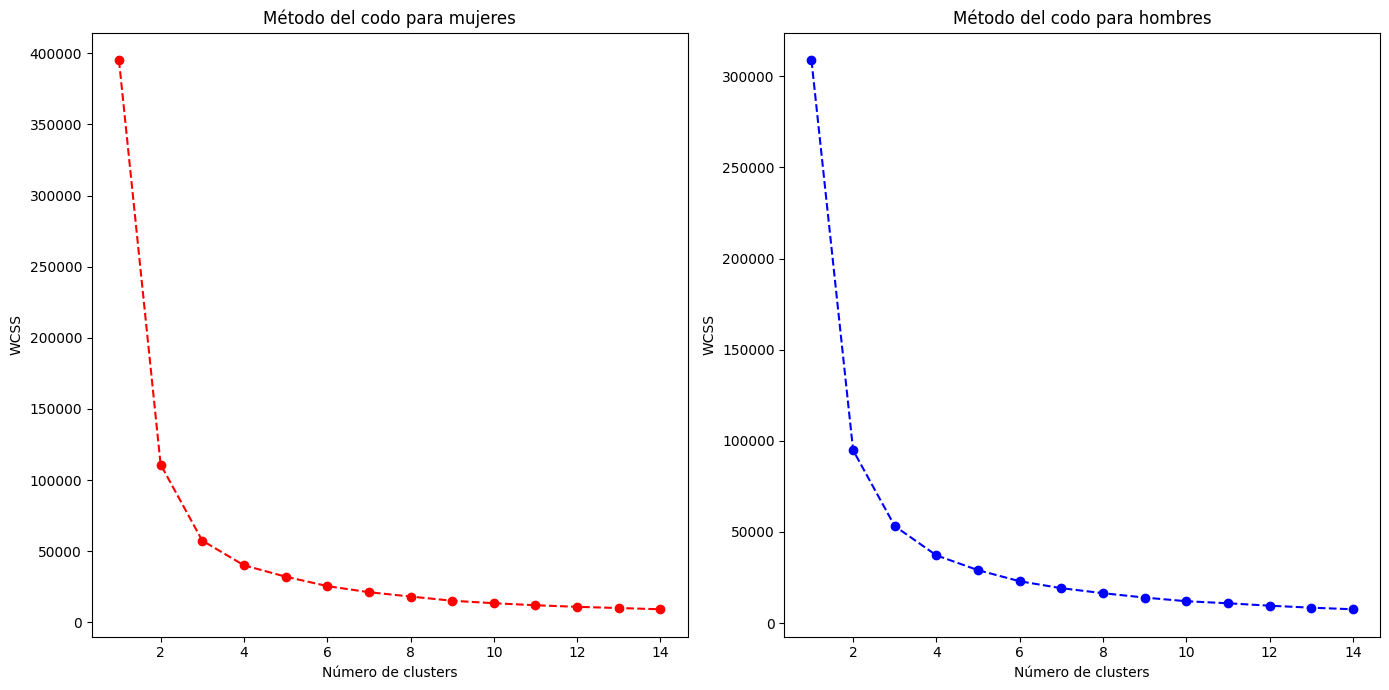

In [32]:
# Método del codo para mujeres
wcss_women = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_women)
    wcss_women.append(kmeans.inertia_)

# Método del codo para hombres
wcss_men = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_men)
    wcss_men.append(kmeans.inertia_)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(range(1, 15), wcss_women, marker='o', linestyle='--', color='red')
plt.title('Método del codo para mujeres')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range(1, 15), wcss_men, marker='o', linestyle='--', color='blue')
plt.title('Método del codo para hombres')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')

plt.tight_layout()
plt.show()

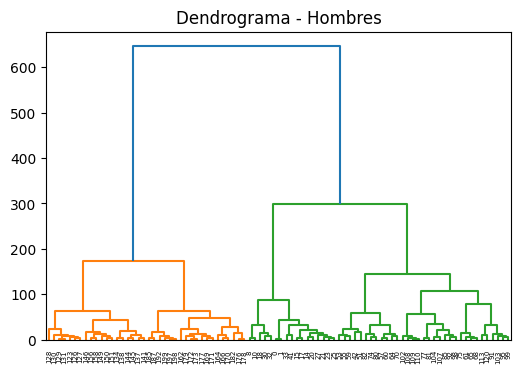

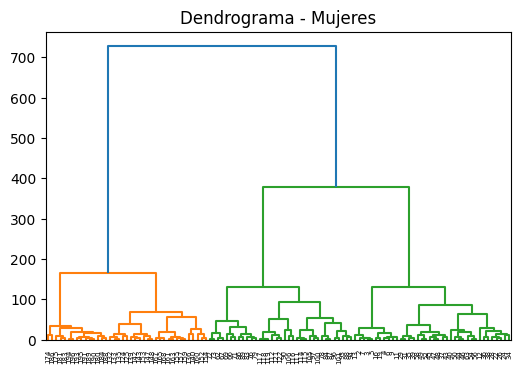

In [33]:
distance_matrix_men = linkage(df_men, method='ward')
distance_matrix_women = linkage(df_women, method='ward')

plt.figure(figsize=(6, 4))
dendrogram(distance_matrix_men, labels=df_men.index)
plt.title('Dendrograma - Hombres')
plt.show()

plt.figure(figsize=(6, 4))
dendrogram(distance_matrix_women, labels=df_women.index)
plt.title('Dendrograma - Mujeres')
plt.show()



In [34]:
# Para mujeres con 6 clusters
kmeans_women = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters_women = kmeans_women.fit_predict(df_women)
df_women = df_women.copy() 
df_women.loc[:, 'Cluster'] = clusters_women

# Para hombres con 5 clusters
kmeans_men = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters_men = kmeans_men.fit_predict(df_men)
df_men = df_men.copy() 
df_men.loc[:, 'Cluster'] = clusters_men


print("Tamaño de cada cluster para mujeres:")
print(df_women['Cluster'].value_counts())

print("\nTamaño de cada cluster para hombres:")
print(df_men['Cluster'].value_counts())


Tamaño de cada cluster para mujeres:
Cluster
5    23
3    23
1    22
2    17
4    15
0    12
Name: count, dtype: int64

Tamaño de cada cluster para hombres:
Cluster
1    20
4    19
0    18
3    17
2    14
Name: count, dtype: int64


In [35]:
# Estadísticas descriptivas para los clusters de mujeres
cluster_stats_women = df_women.groupby('Cluster').mean()
print("Estadísticas de los Clusters para Mujeres:")
cluster_stats_women


Estadísticas de los Clusters para Mujeres:


,CustomerID,Age,Gender_Female,Gender_Male,Age_Group_Young,Age_Group_Adult,Age_Group_Elder,Income_Level_Low,Income_Level_Medium,Income_Level_High,Spending_Level_Low,Spending_Level_Medium,Spending_Level_High
Cluster,,,,,,,,,,,,,
0,9.916667,30.916667,1.0,0.0,0.500000,0.500000,0.000000,1.000000,0.000000,0.0,0.416667,0.000000,0.583333
1,151.409091,35.636364,1.0,0.0,0.318182,0.681818,0.000000,0.000000,0.000000,1.0,0.409091,0.000000,0.590909
2,73.588235,51.058824,1.0,0.0,0.058824,0.647059,0.294118,0.411765,0.588235,0.0,0.000000,1.000000,0.000000
3,108.173913,35.695652,1.0,0.0,0.391304,0.521739,0.086957,0.000000,1.000000,0.0,0.173913,0.739130,0.086957
4,187.600000,38.866667,1.0,0.0,0.133333,0.866667,0.000000,0.000000,0.000000,1.0,0.533333,0.000000,0.466667
5,40.173913,36.521739,1.0,0.0,0.391304,0.565217,0.043478,1.000000,0.000000,0.0,0.391304,0.304348,0.304348


In [36]:
# Estadísticas descriptivas para los clusters de hombres
cluster_stats_men = df_men.groupby('Cluster').mean()
print("Estadísticas de los Clusters para Hombres:")
cluster_stats_men


Estadísticas de los Clusters para Hombres:


,CustomerID,Age,Gender_Female,Gender_Male,Age_Group_Young,Age_Group_Adult,Age_Group_Elder,Income_Level_Low,Income_Level_Medium,Income_Level_High,Spending_Level_Low,Spending_Level_Medium,Spending_Level_High
Cluster,,,,,,,,,,,,,
0,66.222222,47.500000,0.0,1.0,0.222222,0.500000,0.277778,0.611111,0.388889,0.0,0.166667,0.722222,0.111111
1,139.150000,36.150000,0.0,1.0,0.250000,0.750000,0.000000,0.000000,0.400000,0.6,0.500000,0.050000,0.450000
2,102.142857,44.285714,0.0,1.0,0.357143,0.357143,0.285714,0.000000,1.000000,0.0,0.071429,0.928571,0.000000
3,20.705882,36.000000,0.0,1.0,0.470588,0.352941,0.176471,1.000000,0.000000,0.0,0.470588,0.000000,0.529412
4,179.789474,36.473684,0.0,1.0,0.315789,0.684211,0.000000,0.000000,0.000000,1.0,0.526316,0.000000,0.473684


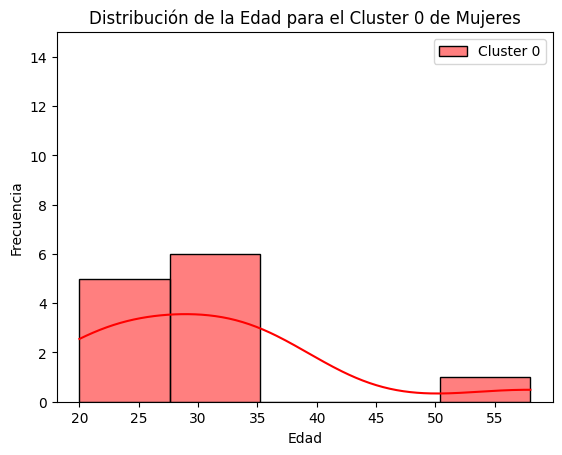

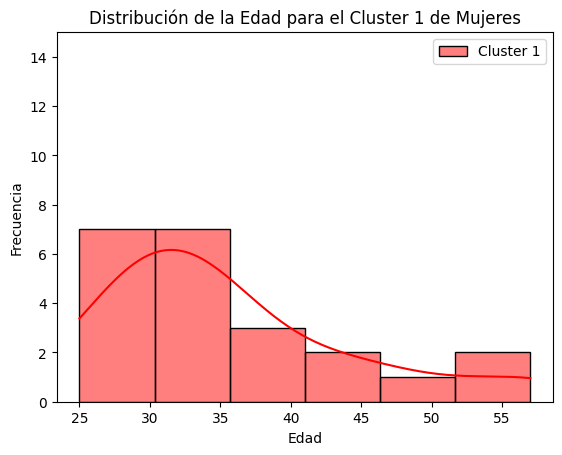

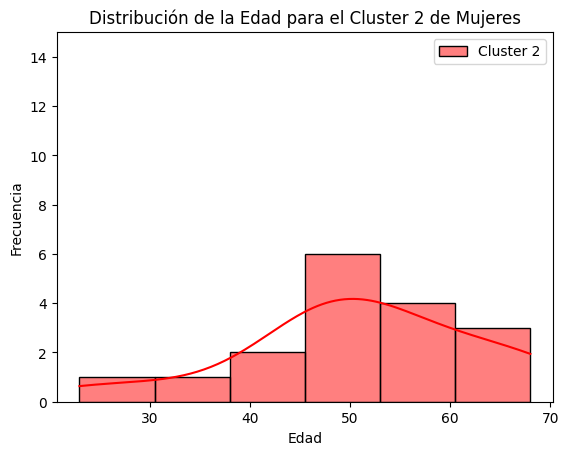

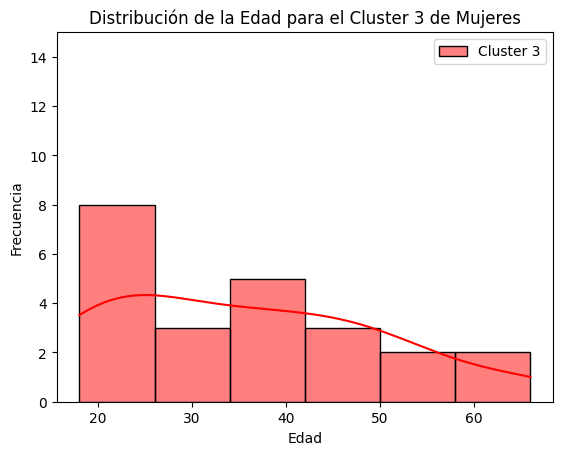

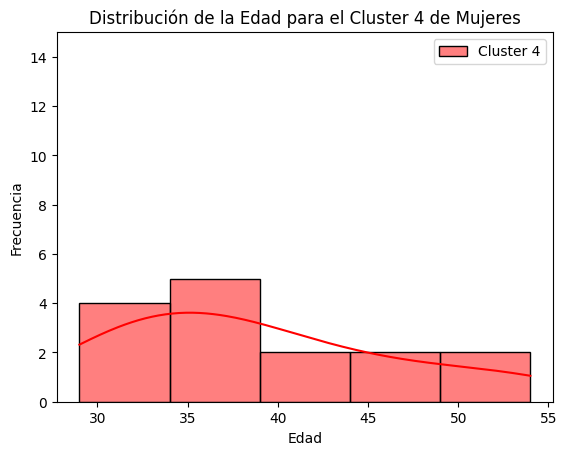

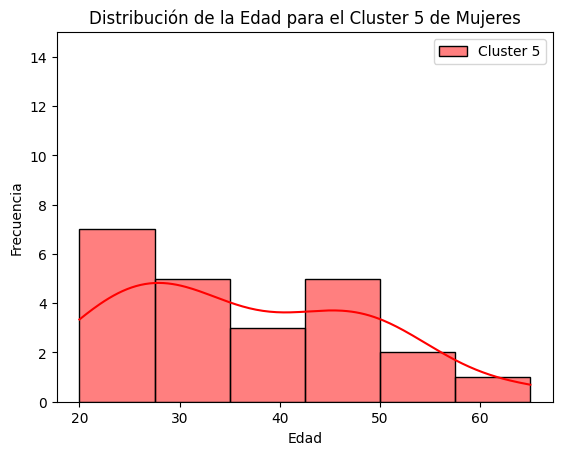

In [37]:
# Histogramas para la edad en los clusters de mujeres
num_clusters_women = df_women['Cluster'].nunique() 

for i in range(num_clusters_women):
    plt.figure()  
    sns.histplot(df_women[df_women['Cluster'] == i]['Age'], kde=True, label=f'Cluster {i}', color='red')
    plt.title(f'Distribución de la Edad para el Cluster {i} de Mujeres')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.ylim(0, 15)
    plt.show()

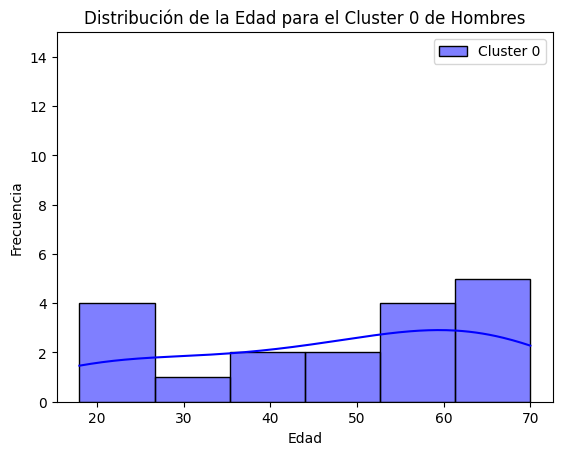

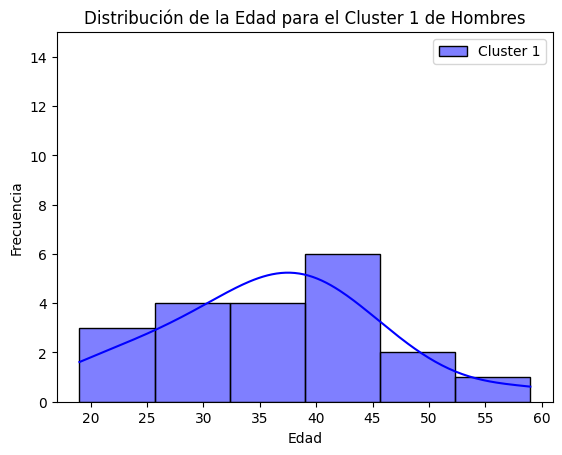

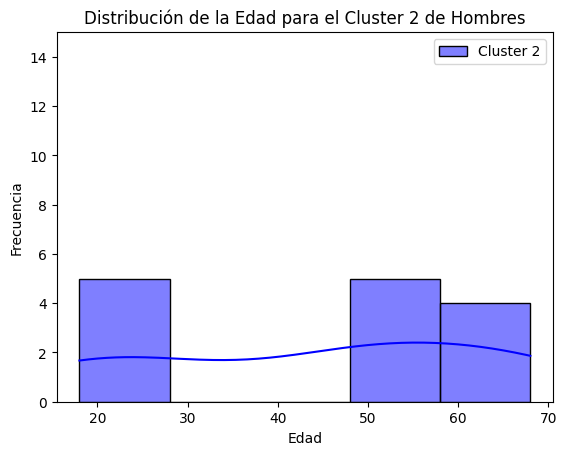

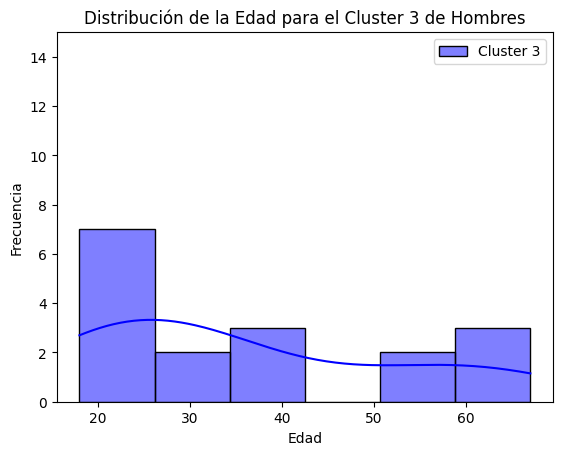

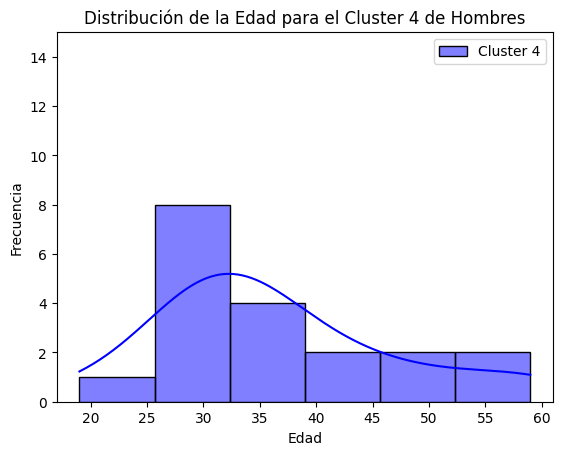

In [38]:
# Histogramas para la edad en los clusters de mujeres
num_clusters_men = df_men['Cluster'].nunique()  

for i in range(num_clusters_men):
    plt.figure()  
    sns.histplot(df_men[df_men['Cluster'] == i]['Age'], kde=True, label=f'Cluster {i}', color='blue')
    plt.title(f'Distribución de la Edad para el Cluster {i} de Hombres')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.ylim(0, 15)
    plt.show()

## Conclusiones:

`df_women`: La segmentación de las clientas me cuenta que para:

Cluster 0:

Características Promedio: Los integrantes tienen una edad promedio de aproximadamente 31 años y están distribuidos equitativamente entre los grupos de edad jóvenes y adultos. Todos presentan ingresos bajos. En términos de gastos, hay una inclinación hacia el nivel de gasto alto, con un porcentaje menor en gasto medio y casi nulo en gasto bajo.

Estrategia de Ventas: Dado que este grupo tiene ingresos bajos pero muestra una tendencia a gastar más, las estrategias podrían enfocarse en productos con buena relación calidad-precio, ofertas especiales y descuentos. También podrían ser atraídos por productos que les permitan cumplir con aspiraciones de estilo de vida más allá de su rango de ingresos.

Cluster 1:

Características Promedio: Este grupo tiene una edad promedio de aproximadamente 36 años, con una ligera inclinación hacia los adultos. Todos tienen ingresos bajos y muestran una tendencia hacia el gasto bajo, aunque una porción significativa también muestra gasto alto.

Estrategia de Ventas: Este grupo podría beneficiarse de estrategias de marketing enfocadas en productos asequibles y de buena calidad. Podrían responder bien a promociones y descuentos, así como a programas de lealtad que ofrezcan valor agregado.

Cluster 2:

Características Promedio: Con una edad promedio de 51 años, este grupo tiende hacia la edad adulta y el envejecimiento, con ingresos mayoritariamente medios y altos. Todos tienen un nivel de gasto medio.

Estrategia de Ventas: Este cluster parece tener capacidad financiera y podría estar interesado en productos de calidad y servicios personalizados. Las estrategias podrían enfocarse en bienes de lujo, comodidad y salud, adecuados para su grupo de edad y poder adquisitivo.

Cluster 3:

Características Promedio: Este grupo tiene una edad promedio de aproximadamente 36 años, con una mayoría en el grupo de edad adulta. Todos tienen ingresos altos. Los niveles de gasto son predominantemente medios, con algunos altos y bajos.

Estrategia de Ventas: Este grupo podría ser el objetivo para productos de gama media a alta. Las estrategias pueden incluir la promoción de productos de calidad y lujo accesible, adecuados para profesionales modernos.

Cluster 4:

Características Promedio: Los miembros de este cluster tienen una edad promedio de unos 39 años y son predominantemente adultos. Este segmento tiene ingresos bajos y una tendencia notable hacia el gasto bajo, aunque hay una proporción considerable que también muestra gasto alto.

Estrategia de Ventas: Dada su situación de ingresos bajos, este grupo podría estar más interesado en productos económicos y ofertas. Sin embargo, la parte del grupo con gasto alto también podría ser atraída por promociones de artículos de lujo asequibles.

Cluster 5:

Características Promedio: Los individuos en este cluster tienen una edad promedio de aproximadamente 37 años, con una distribución bastante equilibrada entre jóvenes y adultos. Todos presentan ingresos bajos, y los niveles de gasto se reparten de manera equitativa entre bajo, medio y alto.

Estrategia de Ventas: Dado la diversidad en los niveles de gasto, las estrategias de marketing deberían variar desde productos económicos hasta de gama media. Podrían beneficiarse de promociones, ofertas especiales, y opciones de pago flexibles para satisfacer las diferentes capacidades y deseos de gasto dentro del cluster.

`df_men`: Y para los hombres:

Cluster 0:

Características Promedio: Los hombres en este cluster tienen una edad promedio de 47.5 años, con una mezcla en los grupos de edad, pero una ligera inclinación hacia los adultos y ancianos. La mayoría tiene ingresos bajos a medios. En cuanto a los gastos, predomina un nivel de gasto medio, con algunos en niveles bajo y alto.

Estrategia de Ventas: Este grupo puede estar interesado en productos y servicios que equilibren calidad y precio, dado su rango de ingresos. Las estrategias de marketing pueden centrarse en la fiabilidad y el valor a largo plazo de los productos, adecuados para la madurez y experiencia de este grupo de edad.

Cluster 1:

Características Promedio: Este grupo tiene una edad promedio de 36.15 años, con una fuerte inclinación hacia la edad adulta. Tienen una distribución de ingresos mayormente media a alta. Los niveles de gasto son variados, con una ligera inclinación hacia el gasto bajo y alto.

Estrategia de Ventas: Dado que este grupo tiene un rango de ingresos más amplio, las estrategias de marketing podrían variar. Podrían responder bien a productos de tecnología, moda y ocio, enfocándose en calidad y tendencias actuales. Las promociones y descuentos especiales también podrían ser efectivos.

Cluster 2:

Características Promedio: Los hombres de este cluster tienen una edad promedio de 44.28 años, con una distribución equilibrada entre jóvenes, adultos y ancianos. Todos tienen ingresos altos. El nivel de gasto es predominantemente medio, con una tendencia notable hacia el gasto alto.

Estrategia de Ventas: Este grupo parece tener una buena posición económica y podría estar interesado en productos de lujo, servicios premium y experiencias exclusivas. Las estrategias de marketing deben enfocarse en destacar la exclusividad, calidad superior y el status que conllevan los productos.

Cluster 3:

Características Promedio: Este grupo tiene una edad promedio de 36 años, con una inclinación hacia la juventud y la adultez. Todos tienen ingresos bajos. Los niveles de gasto son predominantemente altos, con algunos mostrando gasto medio.

Estrategia de Ventas: A pesar de sus bajos ingresos, este cluster muestra una disposición a gastar. Las estrategias podrían centrarse en productos económicos pero de moda, ofertas atractivas y planes de financiación que les permitan realizar compras más significativas.

Cluster 4:

Características Promedio: Los hombres en este cluster tienen una edad promedio de aproximadamente 36.47 años, con una mayor inclinación hacia la edad adulta. Todos presentan ingresos bajos. El gasto es equilibrado entre bajo y alto, sin gastos medios reportados.

Estrategia de Ventas: Este grupo podría estar buscando la mejor relación calidad-precio debido a su situación de ingresos. Las estrategias de marketing pueden incluir promociones, descuentos, y productos que ofrezcan durabilidad y funcionalidad. Los artículos que combinan estilo con practicidad pueden ser especialmente atractivos.